<a href="https://colab.research.google.com/github/MariDamk/cnn-transfer-learning-cats-dogs/blob/main/CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-09-15 18:58:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.4MB/s    in 3.9s    

2025-09-15 18:58:30 (16.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.8326 - loss: 0.3591 - val_accuracy: 0.9590 - val_loss: 0.1032
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9234 - loss: 0.1810 - val_accuracy: 0.9480 - val_loss: 0.1399
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.9371 - loss: 0.1627 - val_accuracy: 0.9640 - val_loss: 0.0856
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.9407 - loss: 0.1605 - val_accuracy: 0.9670 - val_loss: 0.0783
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.9490 - loss: 0.1252 - val_accuracy: 0.9640 - val_loss: 0.0865
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.9606 - loss: 0.1089 - val_accuracy: 0.9710 - val_loss: 0.0820
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9551 - loss: 0.1187 - val_accuracy: 0.9710 - val_loss: 0.0747
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.9465 - loss: 0.1140 - val_accu

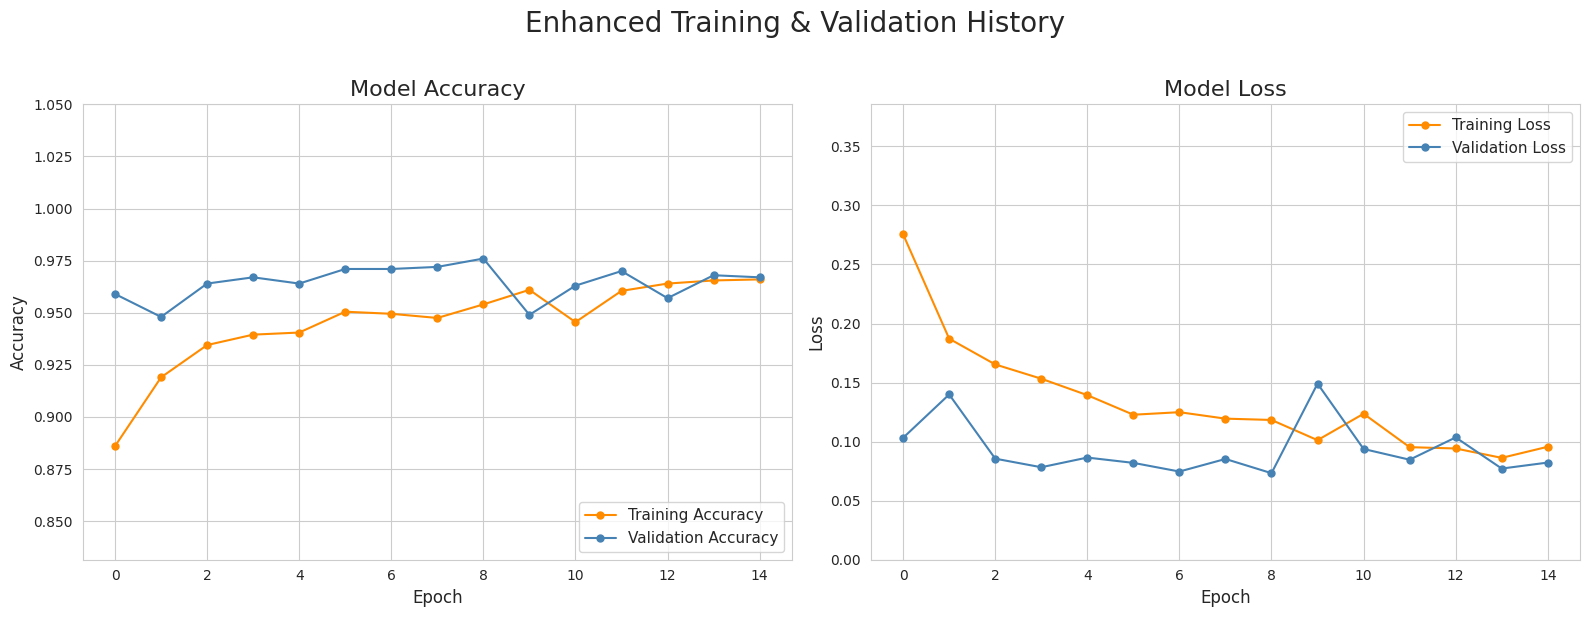

In [ ]:
# Final Project - CNN Cats vs Dogs Image Classification

##Changed to runtime type to T4 GPU instead of CPU, for faster results
## Importing necessary libraries
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


## Defining temporary path and downloading the dataset with wget because for some reason with tf.keras.utils.get_file there was FileNotFound Error
data_path = '/tmp/cats_and_dogs_filtered.zip'
extract_path = '/tmp/'

print("Downloading dataset... Chill...")
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O {data_path}

## Unziping the file
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Directory paths
base_dir = os.path.join(extract_path, 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


IMG_SIZE = 128
BATCH_SIZE = 32

## Modified versions of the images are created to prevnt overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary' ## cat or dog
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


# Using MobileNetV2
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


## Training the model with just 15 epochs
EPOCHS = 15
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

## plotting
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 6))

## Accuracy Plotting
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'o-', label='Training Accuracy', color='darkorange', markersize=5)
    plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy', color='steelblue', markersize=5)
    plt.title('Model Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right', fontsize=11)
    plt.ylim([min(plt.ylim())-0.05, 1.05])

## Loss Plotting
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'o-', label='Training Loss', color='darkorange', markersize=5)
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss', color='steelblue', markersize=5)
    plt.title('Model Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right', fontsize=11)
    plt.ylim([0, max(plt.ylim())+0.1])

    plt.suptitle('Enhanced Training & Validation History', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

plot_history(history)